In [3]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns

import astropy.units as u
import astropy.constants as C

import os
import pickle
import sys
import h5py
import itertools
import importlib
import glob
from tqdm import tqdm

import peters


cp = sns.color_palette("colorblind", 6)

plt.style.use("/Users/michaelzevin/.MATPLOTLIB_RCPARAMS.sty")

In [5]:
# Read in population model(s)
print('Models: ')

run = 'USSN_qc4_stableBBMT'

models = {}
basepath = '/Users/michaelzevin/research/sgrb/pop_models/production/' + run
for f in os.listdir(basepath):
    print('   '+f)
    models[f] = {}
    dirpath = os.path.join(basepath, f)
    keys = list(h5py.File(os.path.join(dirpath,'dat_DeltaBurst_13_13.h5'), 'r').keys())
    for key in keys:
        models[f][key] = pd.read_hdf(os.path.join(dirpath,'dat_DeltaBurst_13_13.h5'), key=key)

Models: 
   Z2
   Z10
   Z20
   Z1


In [6]:
# get the pertinent info from the bpp arrays

for f in models.keys():
    print('Model: {0:s}'.format(f))
    # get pertinent rows in bpp array
    bpp = models[f]['bpp']
    bcm = models[f]['bcm']
    bpp_SN2 = bpp.loc[(bpp['kstar_1']==13) & (bpp['evol_type']==16)]
    bpp_DNS = bpp.loc[(bpp['kstar_1']==13) & (bpp['kstar_2']==13)].groupby(by='bin_num').first()
    bpp_merge = bpp.loc[(bpp['kstar_1']==13) & (bpp['kstar_2']==13)].groupby(by='bin_num').last()
    # account for systems that had mass inversion
    bpp_DNS = bpp_DNS.loc[bpp_SN2.index]

    # create new dataframe with values of interst
    df = pd.DataFrame()
    df['Mpre'] = bpp_SN2['mass_2']
    df['Mpost'] = bpp_DNS['mass_2']
    df['M2'] = bpp_DNS['mass_1']
    df['Apre'] = bpp_SN2['sep']
    df['epre'] = bpp_SN2['ecc']
    df['Apost'] = bpp_DNS['sep']
    df['epost'] = bpp_DNS['ecc']
    df['Vsys'] = bpp_DNS['Vsys_2']
    df['Vk'] = bpp_DNS['SNkick']
    df['Tinsp_cosmic'] = (bpp_merge['tphys']-bpp_DNS['tphys']) * u.Myr.to(u.Gyr)
    
    # calculate inspiral times
    print("   calculating inspiral times...")
    Tinsps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        t = peters.inspiral_time_peters(row['Apost']*u.Rsun.to(u.AU), row['epost'], row['M2'], row['Mpost'])
        if t<0:
            Tinsps.append(np.nan)
        else:
            Tinsps.append(t)
            
    df['Tinsp'] = np.asarray(Tinsps)

    models[f]['DNS'] = df

Model: Z2


  1%|          | 355/39247 [00:00<00:10, 3548.98it/s]

   calculating inspiral times...


100%|██████████| 39247/39247 [00:08<00:00, 4789.69it/s]


Model: Z10


  0%|          | 351/72151 [00:00<00:20, 3505.26it/s]

   calculating inspiral times...


100%|██████████| 72151/72151 [00:16<00:00, 4399.38it/s]


Model: Z20


  1%|          | 334/47528 [00:00<00:14, 3336.84it/s]

   calculating inspiral times...


  0%|          | 0/32859 [00:00<?, ?it/s]

Model: Z1
   calculating inspiral times...


100%|██████████| 32859/32859 [00:06<00:00, 5054.00it/s]


In [14]:
models['Z20']['DNS'].keys()

Index(['Mpre', 'Mpost', 'M2', 'Apre', 'epre', 'Apost', 'epost', 'Vsys', 'Vk',
       'Tinsp_cosmic', 'Tinsp'],
      dtype='object')

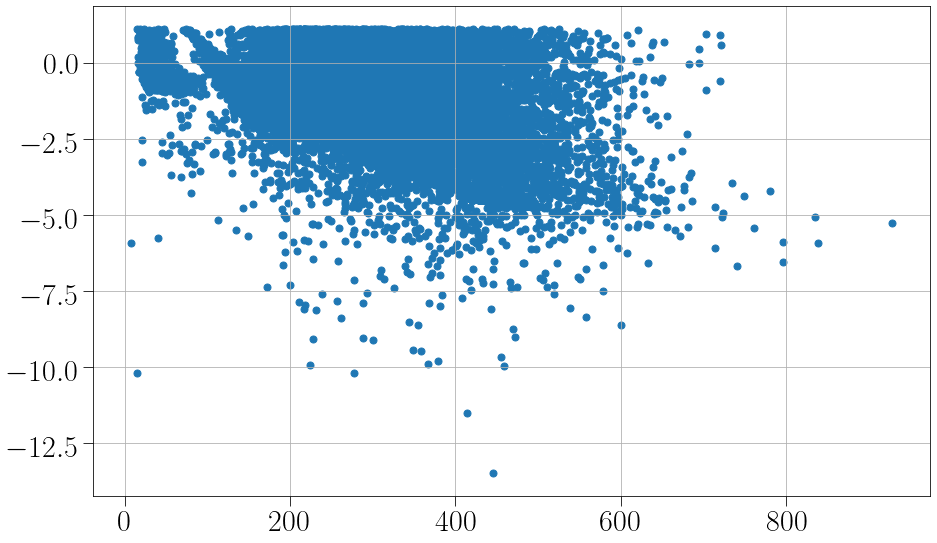

In [15]:
plt.scatter(models['Z20']['DNS']['Vsys'], np.log10(models['Z20']['DNS']['Tinsp']))


### Save population model to dat file

In [7]:
for met in models.keys():
    df = models[met]['DNS']
    df.to_csv(os.path.join('/Users/michaelzevin/research/sgrb/pop_models/production',run,met,'DNS_population.dat'), index=False)

### Compare original models to new ones

In [28]:
Z1_stableBBMT = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/USSN_qc4_stableBBMT/Z1/DNS_population.dat', sep=',')
#Z10_stableBBMT = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/USSN_qc4_stableBBMT/Z10/DNS_population.dat', sep=',')
#Z10_alpha5 = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/USSN_qc4_alpha5/Z10/DNS_population.dat', sep=',')
#Z10_stableBBMT_alpha5 = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/USSN_qc4_stableBBMT_alpha5/Z10/DNS_population.dat', sep=',')
#Z10_bkup = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/old_params/USSN_qc4/Z10/DNS_population.dat', sep=',')
Z10_stableBBMT_bkup = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/production/bkup/Z10/DNS_population.dat', sep=',')

#Z10_bkup = pd.read_csv('/Users/michaelzevin/research/sgrb/pop_models/test_models/Z10_Tauris1_bkup/DNS_population.dat', sep=',')

dfs = [Z1_stableBBMT, Z10_stableBBMT_bkup]
lbls = [r'$USSN\_qc4\_stableBBMT\_Z1$', r'$USSN\_qc4\_stableBBMT\_Z10$']#, r'$USSN\_qc4\_alpha5$', r'$USSN\_qc4\_alpha5\_stableBBMT$']

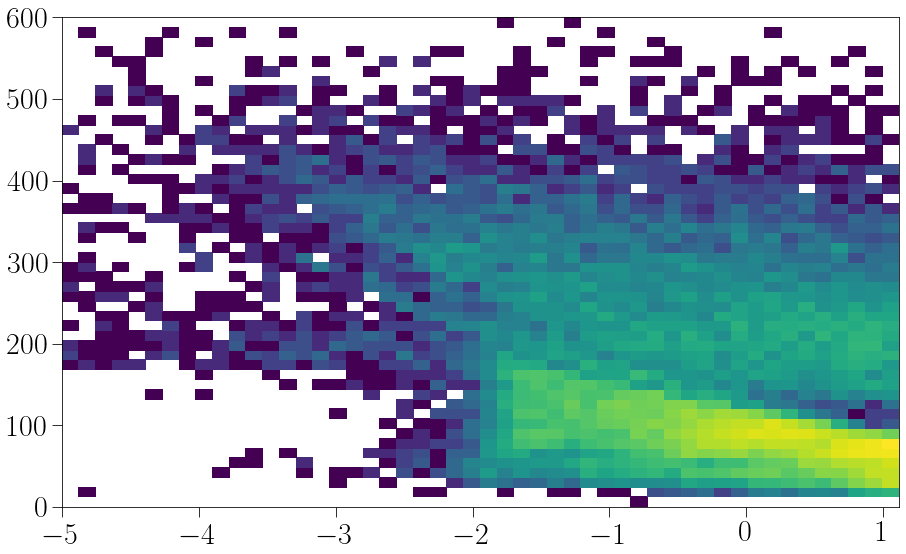

In [29]:
_,_,_,_ = plt.hist2d(np.log10(Z1_stableBBMT['Tinsp']), Z1_stableBBMT['Vsys'], bins=(50,50), range=((-5,np.log10(13)),(0,600)), norm=matplotlib.colors.LogNorm())

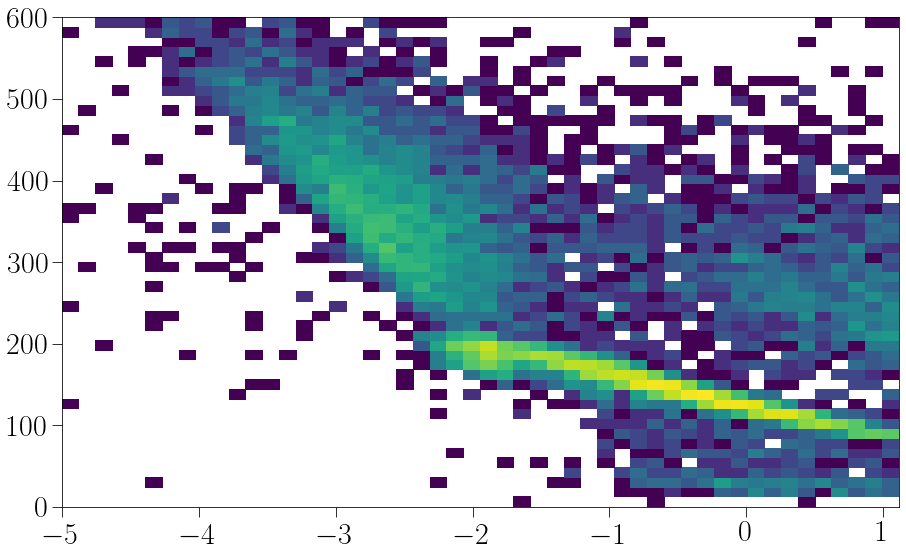

In [30]:
_,_,_,_ = plt.hist2d(np.log10(Z10_stableBBMT_bkup['Tinsp']), Z10_stableBBMT_bkup['Vsys'], bins=(50,50), range=((-5,np.log10(13)),(0,600)), norm=matplotlib.colors.LogNorm())

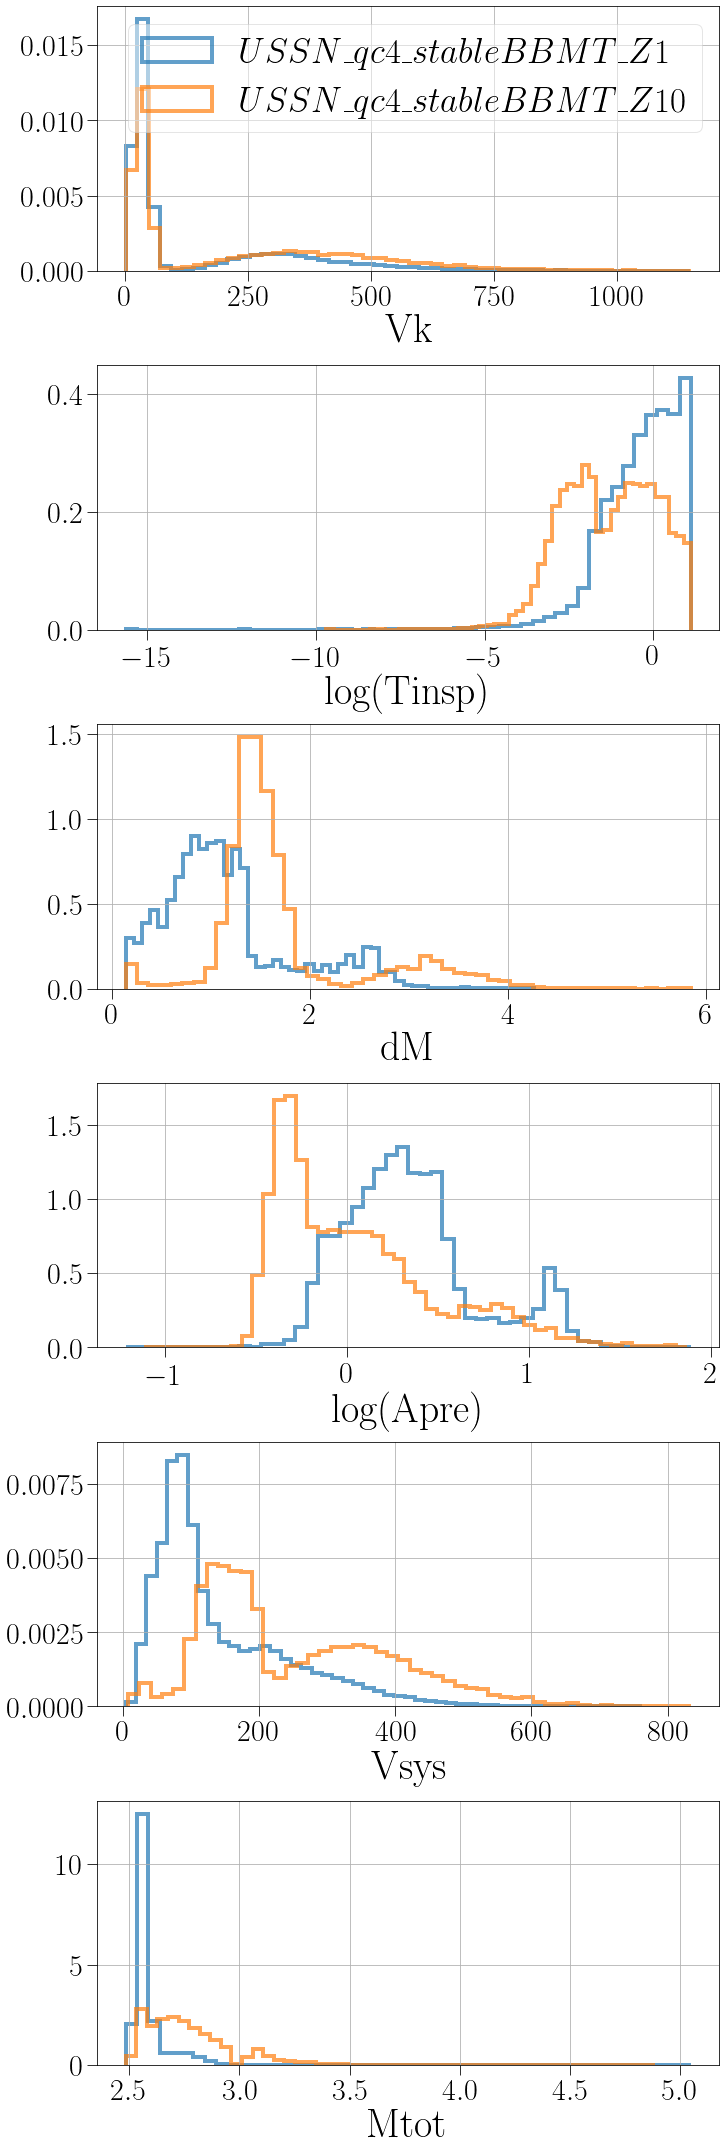

In [31]:
fig, axs = plt.subplots(6,1, figsize=(10,30))

for df, lbl in zip(dfs,lbls):
    _,_,_ = axs[0].hist(df['Vk'], bins=50, density=True, histtype='step', lw=4, alpha=0.7, label=lbl)
axs[0].set_xlabel('Vk')
axs[0].legend(loc='best')

for df in dfs:
    _,_,_ = axs[1].hist(np.log10(df['Tinsp']), bins=50, density=True, histtype='step', lw=4, alpha=0.7)
axs[1].set_xlabel('log(Tinsp)')

for df in dfs:
    _,_,_ = axs[2].hist(df['Mpre']-df['Mpost'], bins=50, density=True, histtype='step', lw=4, alpha=0.7)
axs[2].set_xlabel('dM')

for df in dfs:
    _,_,_ = axs[3].hist(np.log10(df['Apre']), bins=50, density=True, histtype='step', lw=4, alpha=0.7)
axs[3].set_xlabel('log(Apre)')

for df in dfs:
    _,_,_ = axs[4].hist(df['Vsys'], bins=50, density=True, histtype='step', lw=4, alpha=0.7)
axs[4].set_xlabel('Vsys')

for df in dfs:
    _,_,_ = axs[5].hist(df['Mpost']+df['M2'], bins=50, density=True, histtype='step', lw=4, alpha=0.7)
axs[5].set_xlabel('Mtot')

plt.tight_layout()

### Exploration

Text(0.5, 0, '$V_{sys}$ [km s$^{-1}]$')

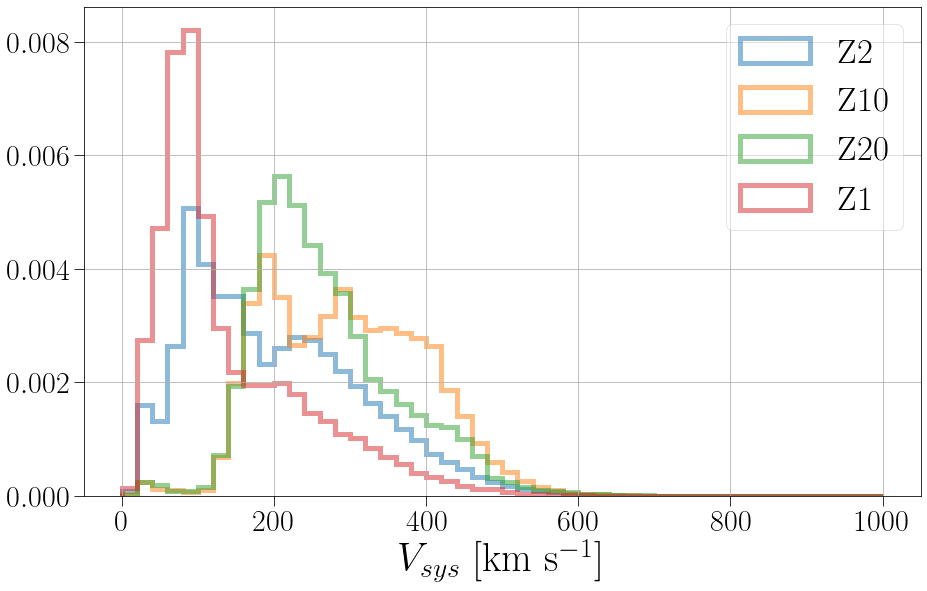

In [32]:
param='Vsys'
lbl='$V_{sys}$ [km s$^{-1}]$'
for f in models.keys():
    _,_,_ = plt.hist(models[f]['DNS'][param], bins=50, range=(0,1000), alpha=0.5, histtype='step', lw=5, density=True, label=f)

plt.legend()
plt.xlabel(lbl)

Text(0.5, 0, '$\\Delta M\\ [M_\\odot]$')

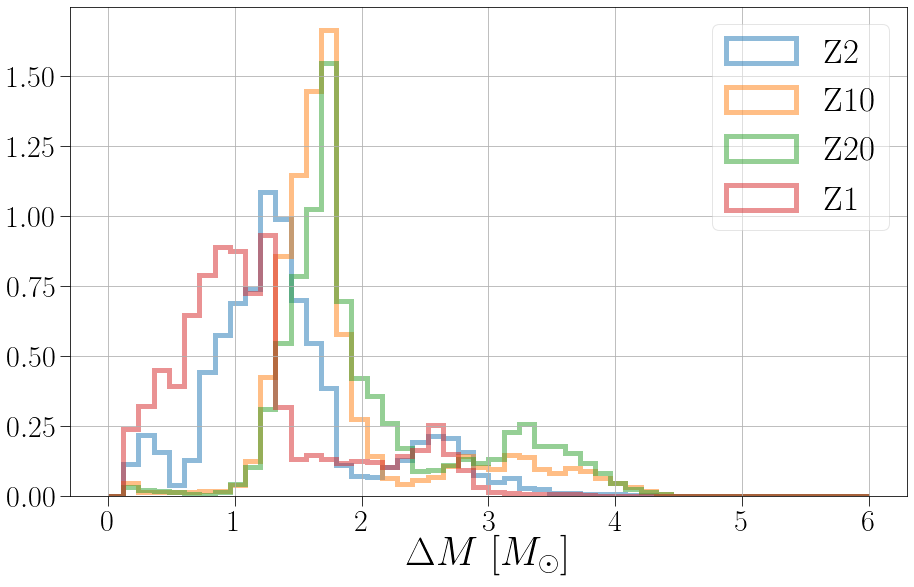

In [33]:
lbl='$\Delta M\ [M_\odot]$'
for f in models.keys():
    _,_,_ = plt.hist(models[f]['DNS']['Mpre']-models[f]['DNS']['Mpost'], bins=50, range=(0,6), alpha=0.5, histtype='step', lw=5, density=True, label=f)

plt.legend()
plt.xlabel(lbl)

Text(0.5, 0, '$V_{k}$ km s$^{-1}$')

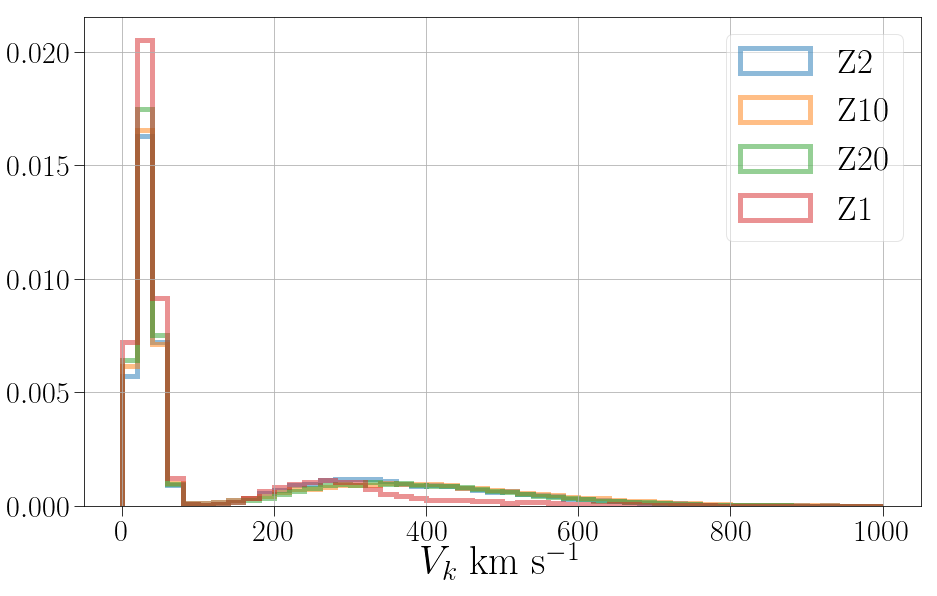

In [28]:
param='Vk'
lbl='$V_{k}$ km s$^{-1}$'
for f in models.keys():
    _,_,_ = plt.hist(models[f]['DNS'][param], bins=50, range=(0,1000), alpha=0.5, histtype='step', lw=5, density=True, label=f)

plt.legend()
plt.xlabel(lbl)

/Users/michaelzevin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0.5, 0, 'log($t_{insp}$/Gyr)')

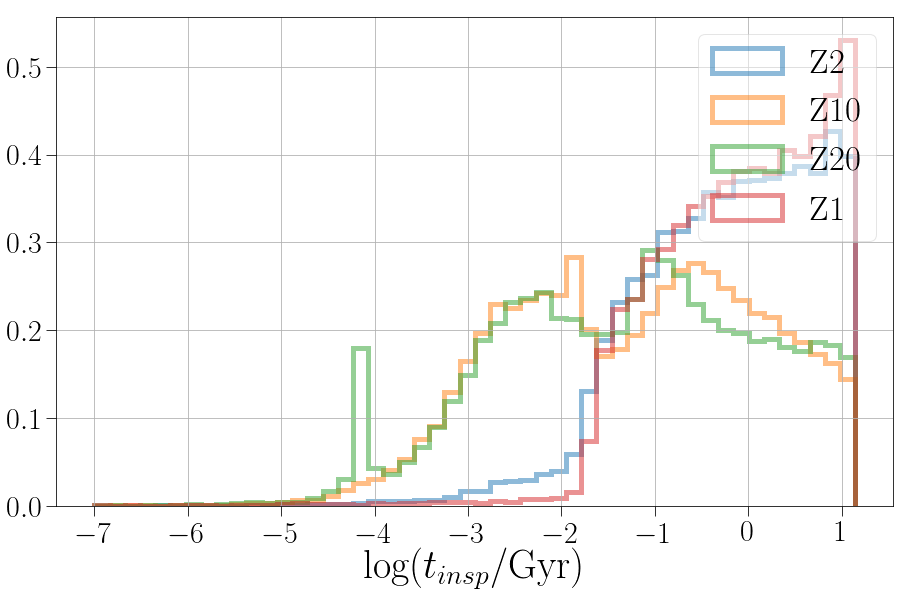

In [22]:
param='Tinsp'
lbl='log($t_{insp}$/Gyr)'
for f in models.keys():
    _,_,_ = plt.hist(np.log10(models[f]['DNS'][param]), bins=50, range=(-7,np.log10(14)), alpha=0.5, histtype='step', lw=5, density=True, label=f)

plt.legend()
plt.xlabel(lbl)

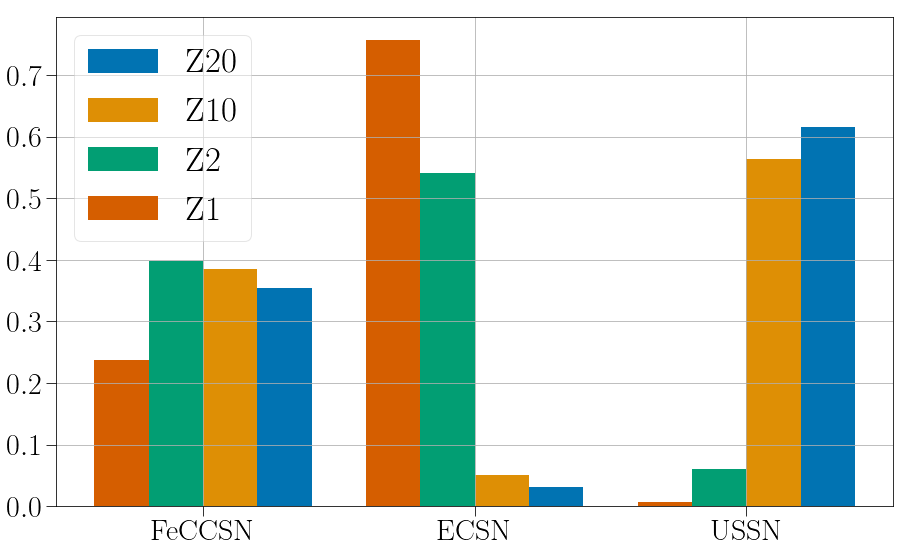

In [29]:
# is this from stripping or ECSNe?
fig, ax = plt.subplots()

bw=0.2
SNtypes = {'FeCCSN':1, 'ECSN':2, 'USSN':3}
mets = {'Z20':-1.5,'Z10':-0.5,'Z2':0.5,'Z1':1.5,}
xvals = np.arange(len(SNtypes.keys()))+1

for SN, SN_idx in SNtypes.items():
    for cidx, (met, midx) in enumerate(mets.items()):
        val = len(np.where(models[met]['bcm']['SN_2'] == SN_idx)[0]) / float(len(models[met]['bcm']['SN_2']))
        
        if SN_idx==1:
            ax.bar(SN_idx - midx*bw, val, bw, align='center', color=cp[cidx], label=met)
        else:
            ax.bar(SN_idx - midx*bw, val, bw, align='center', color=cp[cidx])

ax.set_xticks([1,2,3])
ax.set_xticklabels(['FeCCSN','ECSN','USSN'])
ax.legend()

## Alright, let's look at the things Vicky recommended

#### Re-run populations with altered values in the BSE dict

In [152]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve

In [54]:
# Change to Startrack qcs
model = models['Z1']
initC = models['Z1']['initCond']
initC = initC.assign(ussn=1, qcflag=4)


bpp = pd.DataFrame()
bcm = pd.DataFrame()

for bin_num in tqdm(initC.bin_num.values):
    _bpp, _bcm, _initC = Evolve.evolve(initC.loc[initC.bin_num==bin_num])
    bpp = bpp.append(_bpp)
    bcm = bcm.append(_bcm)


100%|██████████| 27360/27360 [47:51<00:00,  6.31it/s]


In [57]:
# save, if desired

path = os.path.join('/Users/michaelzevin/research/sgrb/pop_models/production/USSN_lam0.5','Z1_qc4','dat_DeltaBurst_13_13.h5')

bpp.to_hdf(path, key='bpp')
bcm.to_hdf(path, key='bcm')
initC.to_hdf(path, key='initCond')

#### See the kstar type of systems that enter CE

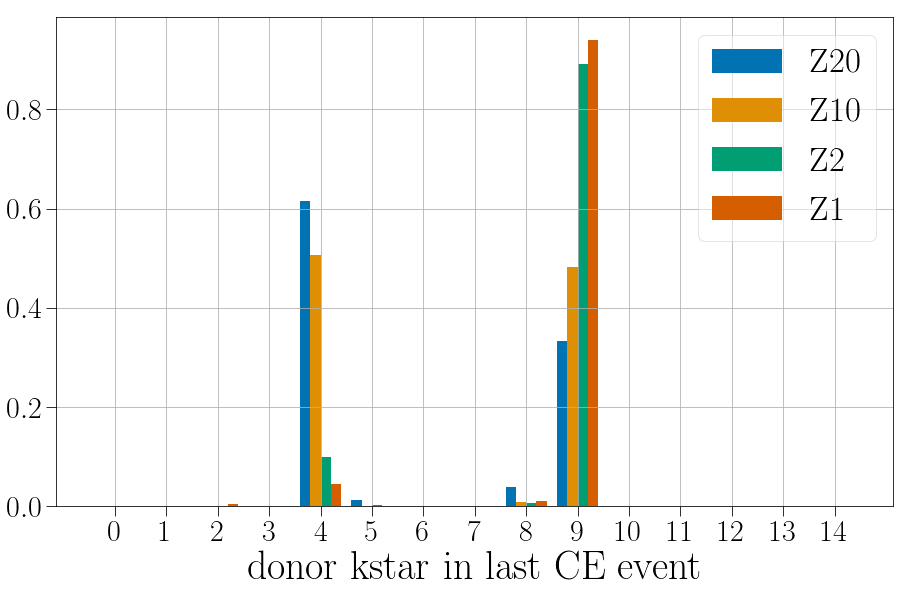

In [255]:
fig, ax = plt.subplots()

bw=0.2
place_dict = {'Z1':-1.5,'Z2':-0.5,'Z10':0.5,'Z20':1.5}
metallicities = ['Z20','Z10','Z2','Z1']
kstar_vals = np.arange(15)

for midx, met in enumerate(metallicities):
    bpp = models[met]['bpp']
    lastCE = bpp.loc[bpp['evol_type']==7].groupby('bin_num').last()
    
    heights = []
    for kstar in kstar_vals:
        height = float(len(lastCE[lastCE['kstar_2']==kstar]))/len(lastCE)

        if kstar==0:
            ax.bar(kstar - place_dict[met]*bw, height, bw, align='center', color=cp[midx], label=met)
        else:
            ax.bar(kstar - place_dict[met]*bw, height, bw, align='center', color=cp[midx])

ax.set_xticks(kstar_vals)
ax.set_xticklabels(kstar_vals)
ax.set_xlabel('donor kstar in last CE event')
ax.legend()

#### See number of CEs that each system goes through

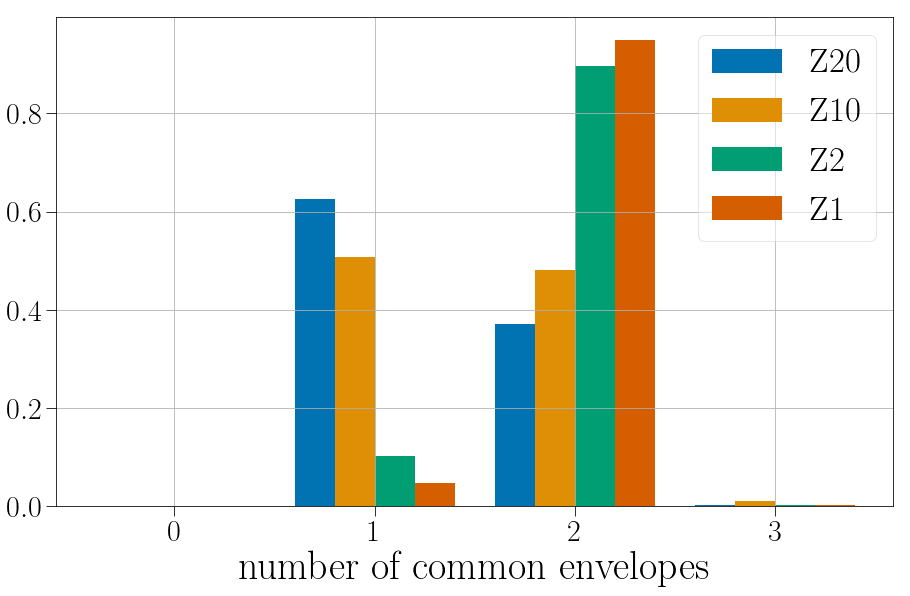

In [256]:
fig, ax = plt.subplots()

bw=0.2
place_dict = {'Z1':-1.5,'Z2':-0.5,'Z10':0.5,'Z20':1.5}
metallicities = ['Z20','Z10','Z2','Z1']
number_of_CEs = [0,1,2,3]

for midx, met in enumerate(metallicities):
    bpp = models[met]['bpp']
    nCEs = bpp.loc[bpp['evol_type']==7].groupby('bin_num').size()
    
    heights = []
    for N in number_of_CEs:
        height = float(len(nCEs[nCEs==N]))/len(nCEs)

        if N==0:
            ax.bar(N - place_dict[met]*bw, height, bw, align='center', color=cp[midx], label=met)
        else:
            ax.bar(N - place_dict[met]*bw, height, bw, align='center', color=cp[midx])

ax.set_xticks(number_of_CEs)
ax.set_xticklabels(number_of_CEs)
ax.set_xlabel('number of common envelopes')
ax.legend()

#### Plot a and e for DNS systems at formation in each model

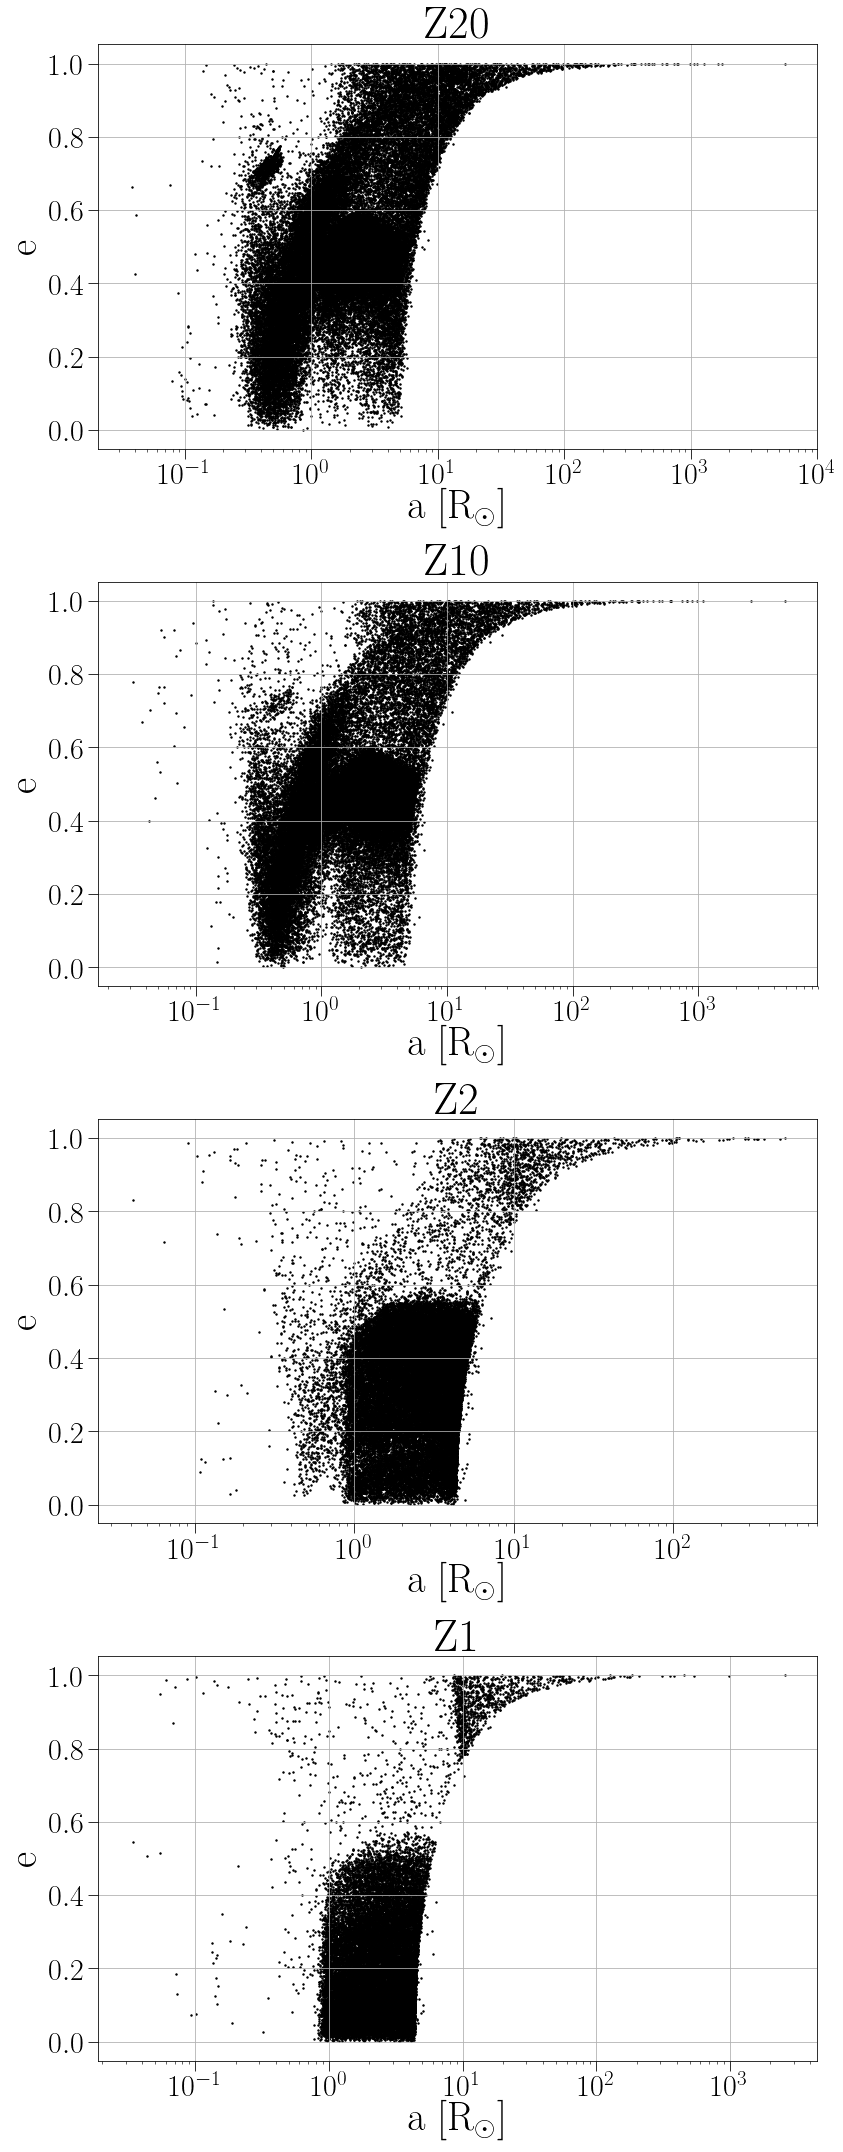

In [257]:
fig, axs = plt.subplots(len(models),1, figsize=(12,30))
metallicities = ['Z20','Z10','Z2','Z1']

for idx, met in enumerate(metallicities):
    df = models[met]['DNS']
    
    axs[idx].scatter(df['Apost'], df['epost'], marker='o', s=2, color='k')
    axs[idx].set_xlabel('a [R$_{\odot}$]')
    axs[idx].set_ylabel('e')
    axs[idx].set_xscale('log')
    axs[idx].set_title(met)

plt.tight_layout()


#### double-check that BSE is drawing kicks correctly

In [245]:
# rewrite kick from BSE
sigma=265

v = np.zeros(3)

def gen_kick():
    for k in [1,2]:
        u1 = np.random.rand()
        u2 = np.random.rand()
        if u1>0.9999:
            u1 = 0.9999
        if u2>1.0:
            u2=1.0

        s = -2.0*np.log(1.0 - u1)
        s = sigma*np.sqrt(s)
        theta = 2.0*np.pi*u2

        # zero-indexing in python
        try:
            v[(2*k-1)-1] = s*np.cos(theta)
        except:
            continue
        try:
            v[(2*k)-1] = s*np.sin(theta)
        except:
            continue
            
    return np.linalg.norm(v)

vs = []
for i in np.arange(100000):
    vs.append(gen_kick())

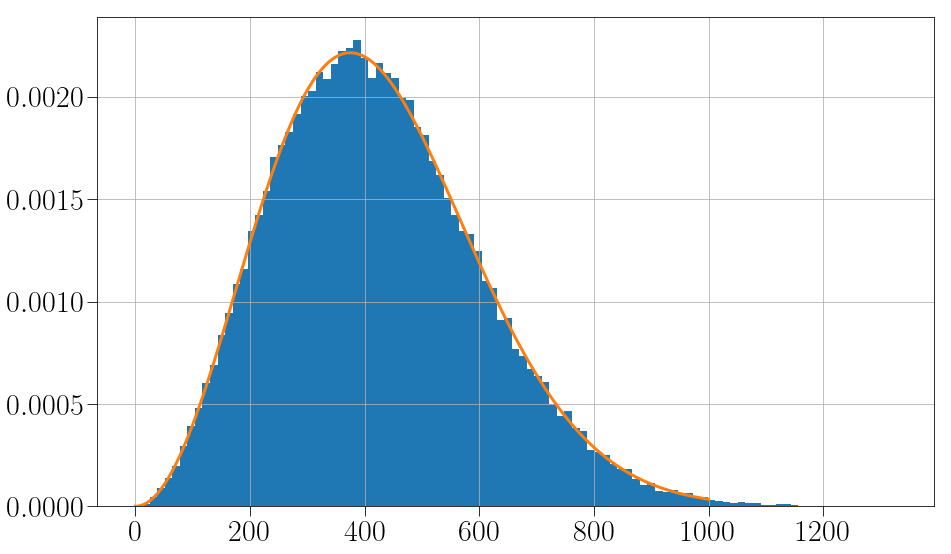

In [246]:
# compare with scipy and plot
    

xvals = np.linspace(0,1000,1000)
yvals = stats.maxwell.pdf(xvals, scale=265)

_,_,_ = plt.hist(vs, bins=100, density=True)
plt.plot(xvals, yvals)

### Test on metallicty runs for Mohammad

In [100]:
basepath = "/Users/michaelzevin/research/r_process/production_models/metallicity_tests"
mets = os.listdir(basepath)

# Read in population model(s)
print('Models: ')

models = {}
for f in mets:
    print('Model: {0:s}'.format(f))
    models[f] = {}
    dirpath = os.path.join(basepath, f)
    models[f]['bcm'] = pd.read_hdf(os.path.join(dirpath,'dat_DeltaBurst_13_13.h5'), key='bcm')
    models[f]['bpp'] = pd.read_hdf(os.path.join(dirpath,'dat_DeltaBurst_13_13.h5'), key='bpp')
    models[f]['initC'] = pd.read_hdf(os.path.join(dirpath,'dat_DeltaBurst_13_13.h5'), key='initCond')

    # get pertinent rows in bpp array
    bpp = models[f]['bpp']
    
    ### FIXME need to change this...
    bpp_SN2 = bpp.loc[(bpp['kstar_1']==13) & (bpp['evol_type']==16)]
    bpp_DNS = bpp.loc[(bpp['kstar_1']==13) & (bpp['kstar_2']==13)].groupby(by='bin_num').first()
    # account for systems that had mass inversion
    bpp_DNS = bpp_DNS.loc[bpp_SN2.index]

    # create new dataframe with values of interst
    df = pd.DataFrame()
    df['Mpre'] = bpp_SN2['mass_2']
    df['Mpost'] = bpp_DNS['mass_2']
    df['M2'] = bpp_DNS['mass_1']
    df['Apre'] = bpp_SN2['sep']
    df['epre'] = bpp_SN2['ecc']
    df['Apost'] = bpp_DNS['sep']
    df['epost'] = bpp_DNS['ecc']
    df['Vsys'] = bpp_DNS['Vsys_2']
    df['Vk'] = bpp_DNS['SNkick']

    # calculate inspiral times
    print("   calculating inspiral times...")
    Tinsps = []
    for idx, row in tqdm(df.iterrows()):
        t = peters.inspiral_time_peters(row['Apost']*u.Rsun.to(u.AU), row['epost'], row['M2'], row['Mpost'])
        if t<0:
            Tinsps.append(np.nan)
        else:
            Tinsps.append(t)
            
    df['Tinsp'] = np.asarray(Tinsps)

    models[f]['DNS'] = df

Models: 
Model: endCE_Z1


0it [00:00, ?it/s]
0it [00:00, ?it/s]

   calculating inspiral times...
Model: endCE_Z2
   calculating inspiral times...
Model: endCE_Z5



0it [00:00, ?it/s]
0it [00:00, ?it/s]

   calculating inspiral times...
Model: endCE_Z100
   calculating inspiral times...
Model: endCE_Z10



0it [00:00, ?it/s]

   calculating inspiral times...
Model: endCE_Z20



0it [00:00, ?it/s]

   calculating inspiral times...
